# Common mistakes

## 1. Creating cells without `cell` decorator

The cell decorator names cells deterministically and uniquely based on the name of the functions and its parameters.

It also uses a caching mechanisms that improves performance and guards against duplicated names.

### 1.1 naming cells manually

Naming cells manually is susceptible to name colisions

in GDS you can't have two cells with the same name.

For example: this code will raise a `duplicated cell name ValueError`

```python

import gdsfactory as gf

c1 = gf.Component('wg')
c1 << gf.components.straight(length = 5)


c2 = gf.Component('wg')
c2 << gf.components.straight(length = 50)


c3 = gf.Component('waveguides')
wg1 = c3 << c1
wg2 = c3 << c2
wg2.movey(10)
c3

```

**Solution**: Use the `gf.cell` decorator for automatic naming your components.

In [1]:
import gdsfactory as gf


@gf.cell
def wg(length: float = 3):
    return gf.components.straight(length=length)


print(wg(length=5))
print(wg(length=50))

2022-11-07 00:11:00.205 | INFO     | gdsfactory.config:<module>:45 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.54.0


Cell ("wg_length5", 4 polygons, 2 paths, 2 labels, 0 references)
Cell ("wg_length50", 4 polygons, 2 paths, 2 labels, 0 references)


### 1.2 Not naming components with a unique and deterministic name

In the case of not wrapping the function with `cell` you will get unique names thanks to the unique identifier `uuid`.

This name will be different and non-deterministic for different invocations of the script.

However it will be hard for you to know where that cell came from.



In [2]:
c1 = gf.Component()
c2 = gf.Component()

print(c1.name)
print(c2.name)

Unnamed_33307674
Unnamed_7ca41836


Notice how gdsfactory raises a Warning when you save this `Unnamed` Components

In [3]:
c1.write_gds()

/home/runner/work/gdsfactory/gdsfactory/gdsfactory/component.py:1328: UserWarning: Component 'Unnamed_33307674' contains 1 Unnamed cells
  warnings.warn(
2022-11-07 00:11:01.068 | INFO     | gdsfactory.component:write_gds:1336 - Write GDS to '/tmp/tmpfv1n1hp5/gdsfactory/Unnamed_33307674.gds'


PosixPath('/tmp/tmpfv1n1hp5/gdsfactory/Unnamed_33307674.gds')

### 1.3 Intermediate Unnamed cells

While creating a cell, you should not create intermediate cells, because they won't get a name.

[ComponentReference (parent Component "Unnamed_f14ea35a", ports [], origin [-5.  0.], rotation 0, x_reflection False)]


/home/runner/work/gdsfactory/gdsfactory/gdsfactory/component.py:1328: UserWarning: Component 'die_bad' contains 1 Unnamed cells
  warnings.warn(


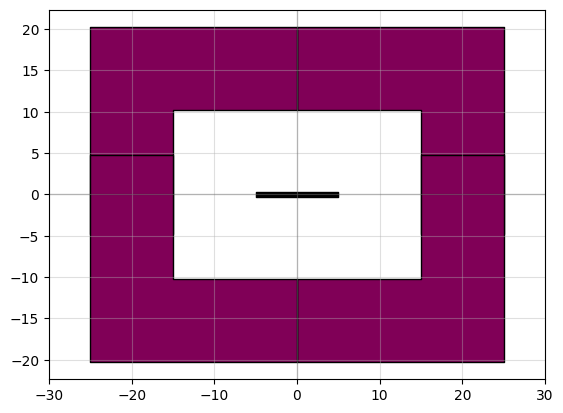

die_bad: uid 810fe08c, ports [], references ['Unnamed_f14ea35a_1'], 4 polygons

In [4]:
@gf.cell
def die_bad():
    """c1 is an intermediate Unnamed cell"""
    c1 = gf.Component()
    c1 << gf.components.straight(length=10)
    c2 = gf.components.die_bbox(c1, street_width=10)
    return c2


c = die_bad(cache=False)
print(c.references)
c

**Solution1** Don't use intermediate cells

[ComponentReference (parent Component "straight_length10", ports ['o1', 'o2'], origin (0, 0), rotation 0, x_reflection False), ComponentReference (parent Component "die_bbox_frame_d6368d3a", ports [], origin (0, 0), rotation 0, x_reflection False)]


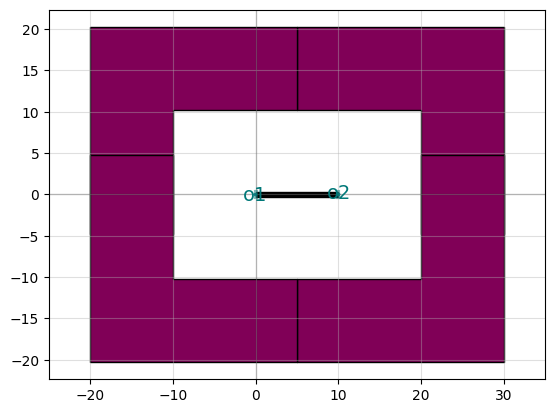

die_good: uid 25fde44d, ports [], references ['straight_1', 'die_bbox_frame_1'], 0 polygons

In [5]:
@gf.cell
def die_good():
    c = gf.Component()
    c << gf.components.straight(length=10)
    c << gf.components.die_bbox_frame(c.bbox, street_width=10)
    return c


c = die_good(cache=False)
print(c.references)
c

**Solution2** You can flatten the cell, but you will lose the memory savings from cell references. Solution1 is more elegant.

[]


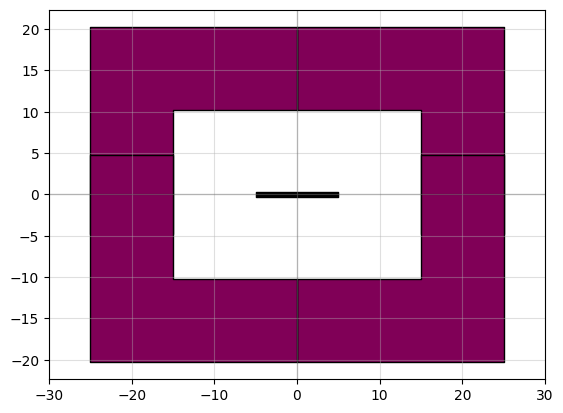

die_flat: uid 0f38268e, ports [], references [], 10 polygons

In [6]:
@gf.cell
def die_flat():
    """c will be an intermediate unnamed cell"""
    c = gf.Component()
    c << gf.components.straight(length=10)
    c2 = gf.components.die_bbox(c, street_width=10)
    c2 = c2.flatten()
    return c2


c = die_flat(cache=False)
print(c.references)
c